In [5]:

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from xgboost import XGBClassifier
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the data
data = pd.read_csv('modified_final_pca_dataframe.csv')

# Extracting PCA features and the target variable
X = data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]
y = data['age_group']

# Encoding target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Defining base models
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(max_iter=1000, random_state=42)  # Simple NN
}

# Training base models and getting predictions
base_predictions = {}
for name, model in base_models.items():
    model.fit(X_train, y_train)
    predictions = cross_val_predict(model, X_train, y_train, cv=5)
    base_predictions[name] = predictions

# Combining predictions for stacked model
X_train_stacked = np.column_stack([base_predictions[name] for name in base_models.keys()])
X_test_stacked = np.column_stack([model.predict(X_test) for _, model in base_models.items()])

# Final model - XGBoost
final_model = XGBClassifier(random_state=42)
final_model.fit(X_train_stacked, y_train)

# Save final model
joblib.dump(final_model, 'stacked_models_agegroup.pkl')

# Making predictions and evaluating the final model
y_pred = final_model.predict(X_test_stacked)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


/Users/surbhitkumar/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/surbhitkumar/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/surbhitkumar/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/surbhitkumar/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future

Accuracy: 0.40083083760023186
Confusion Matrix:
 [[1002  823 1735]
 [ 725 1202 1360]
 [ 771  788 1945]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.28      0.33      3560
           1       0.43      0.37      0.39      3287
           2       0.39      0.56      0.46      3504

    accuracy                           0.40     10351
   macro avg       0.40      0.40      0.39     10351
weighted avg       0.40      0.40      0.39     10351



Confusion matrix, without normalization
Normalized confusion matrix


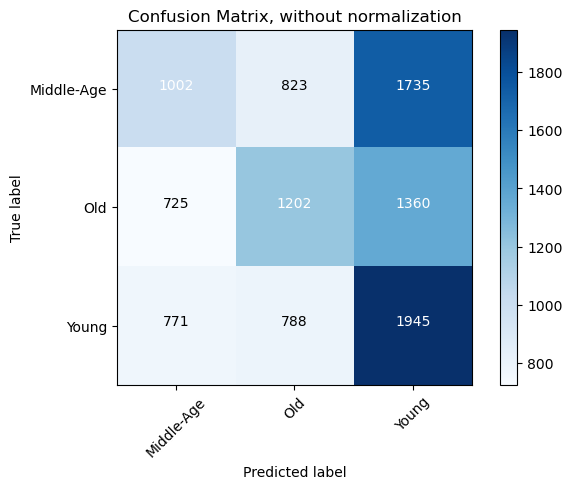

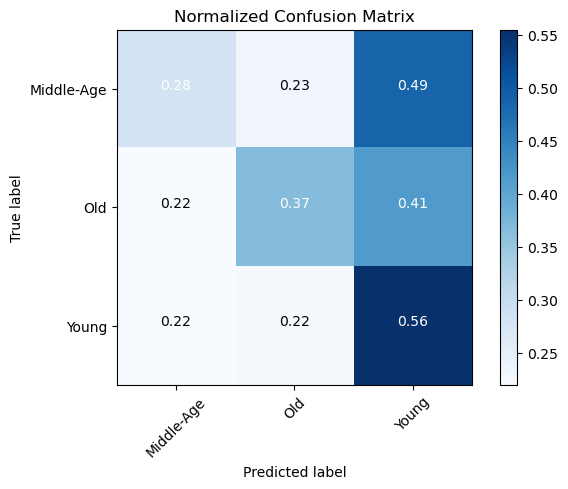

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.28      0.33      3560
           1       0.43      0.37      0.39      3287
           2       0.39      0.56      0.46      3504

    accuracy                           0.40     10351
   macro avg       0.40      0.40      0.39     10351
weighted avg       0.40      0.40      0.39     10351



In [7]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_encoder.classes_,
                      title='Confusion Matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_encoder.classes_, normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()
print("Classification Report:\n", class_report)